In [4]:
# Fix 
import sys
import os
PROJECT_BASE = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
assert PROJECT_BASE.split("/")[-1] == "real-nvp"
sys.path.append(PROJECT_BASE)

In [3]:
%load_ext autoreload
%autoreload 2

import time
import itertools
from functools import reduce

import tensorflow as tf
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.special import logsumexp

from real_nvp.real_nvp import RealNVP
from examples.real_nvp_2d_rl_example import RealNVP2dRlExample

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)

ImportError: No module named 'real_nvp'

In [4]:
SEED = np.random.randint(1, 4)
print("SEED: ", SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

SEED:  1


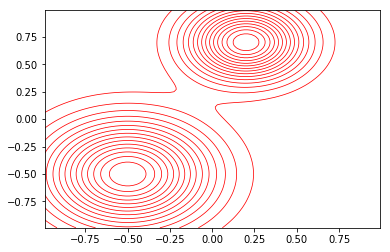

In [5]:
MEANS = np.array([[0.2, 0.7], [-0.5, -0.5]])
VARIANCES = np.array([[0.05, 0.05], [0.1, 0.1]])
WEIGHTS = np.array([0.5, 1.0])

def _get_mesh_points():
    xs = np.linspace(-0.99, 0.99, 100)
    ys = np.linspace(-0.99, 0.99, 100)
    mesh_x, mesh_y = np.meshgrid(xs, ys)

    mesh = np.stack((mesh_x.ravel(), mesh_y.ravel()), axis=1)
    
    return mesh, mesh_x, mesh_y

def _log_gaussian_2d(mu, var, actions):
    weighted_sq_diff = (actions - mu[None])**2 / var[None]
    weighted_sq_sum = np.sum(weighted_sq_diff, axis=1, keepdims=True)
    log_Z = - np.sum(0.5 * np.log(var)) - np.log(2 * np.pi)
    log_gauss = log_Z - weighted_sq_sum / 2

    return log_gauss  # N x 1

def target_Q(weights, means, variances, actions):
    target_log_components = [
        _log_gaussian_2d(mean, variance, actions) + np.log(weight)
        for weight, mean, variance in zip(weights, means, variances)
    ]

    target_log_components = np.concatenate(target_log_components, axis=1)
    
    logsumexps = logsumexp(target_log_components, axis=1) # N
    
    return logsumexps

actions, mesh_x, mesh_y = _get_mesh_points()

log_target_Qs = target_Q(WEIGHTS, MEANS, VARIANCES, actions).reshape(mesh_x.shape)
cs_target = plt.contour(mesh_x, mesh_y, np.exp(log_target_Qs), 15, colors='r', linewidths=0.75)

In [ ]:
tf.reset_default_graph()

%matplotlib notebook

subplots = fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.ion()
ax.set_xlim((-2.1, 2.1))
ax.set_ylim((-2.1, 2.1))
ax.grid(True)

fig.canvas.draw()

example = RealNVP2dRlExample(subplots, WEIGHTS, MEANS, VARIANCES)
example.run()